In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date
import warnings

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import importlib
import scripts.Strategy as ss

%load_ext autoreload
%autoreload 2
#importlib.reload(ss) #above magic works so won't need to manual reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def create_dogleash(df, win):
    
    dog_leash=df.copy()
    dog_leash=dog_leash.rolling(window=win).mean()
    dog_leash.dropna(inplace=True)
    c=np.polyfit(dog_leash.iloc[:, 0], dog_leash.iloc[:, 1], 1)
    dog_leash['Dog_leash']=dog_leash.iloc[:, 1]-c[0]*dog_leash.iloc[:, 0]
    dog_leash=dog_leash[['Dog_leash']]
    newcol_name=f'Dogleash_{win}'
    dog_leash.rename(columns={'Dog_leash':newcol_name}, inplace=True)
    
    return dog_leash

In [12]:
#data prepare
warnings.filterwarnings('ignore')
start=date(1990, 1, 1)
end=date(2020, 11, 23)

stock_list=['BABA', 'BBY']
stock_pair=yf.download(stock_list, start, end, progress = False)

stock_pair=stock_pair[['Adj Close']].copy()
stock_pair.dropna(how='any', axis=0, inplace=True)
stock_pair.columns=stock_pair.columns.droplevel()
stock_pair.index=pd.DatetimeIndex(stock_pair.index)
#stock_pair.head()
dogleash_5=create_dogleash(stock_pair, 5)
test_data=pd.merge(stock_pair, dogleash_5, how='outer', on='Date')
dogleash_20=create_dogleash(stock_pair, 20)
test_data=pd.merge(test_data, dogleash_20, how='outer', on='Date')

c=np.polyfit(test_data.iloc[:, 0], test_data.iloc[:, 1], 1)
test_data['realcombo']=-test_data.iloc[:,0]*c[0]+test_data.iloc[:,1]
#test_data.dropna(how='any', axis=0, inplace=True)
test_data=test_data.reset_index()

In [102]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 6 columns):
Date           1556 non-null datetime64[ns]
BABA           1556 non-null float64
BBY            1556 non-null float64
Dogleash_5     1552 non-null float64
Dogleash_20    1537 non-null float64
realcombo      1556 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 73.1 KB


In [151]:
#################################################run model and get model's info###########################################
model=SARIMAX(test_data.loc[:,'realcombo'] , order=(4, 0, 14), trend='ct')
results=model.fit()

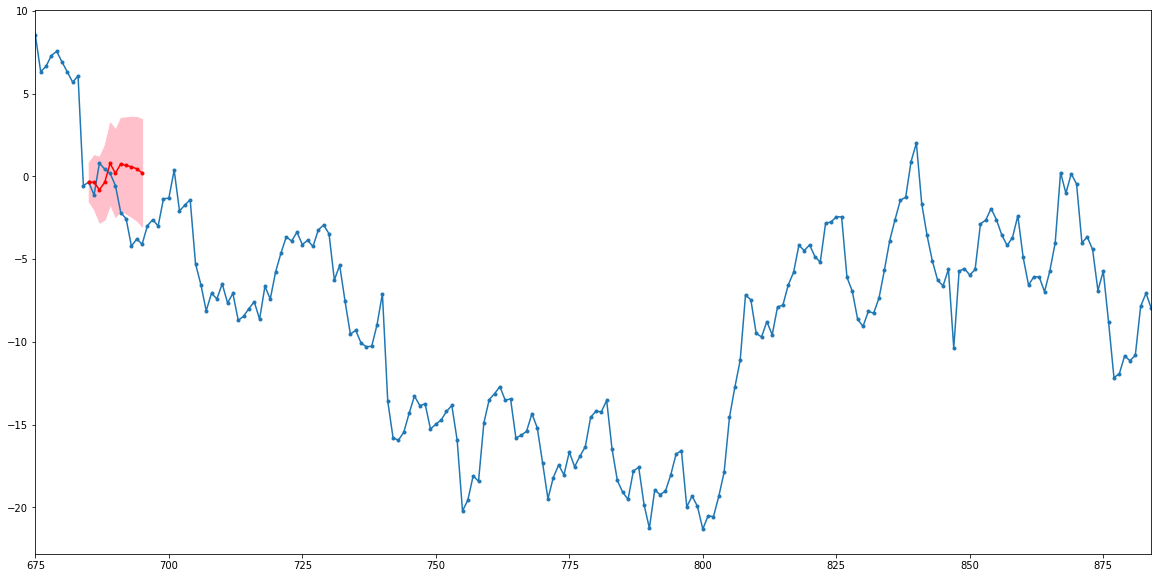

In [199]:
index=685
test_start=-len(test_data)+index
back_forecast=results.get_prediction(start=test_start, end=test_start+10, dynamic=True)
mean_forecast=back_forecast.predicted_mean
conf_intervals=back_forecast.conf_int(alpha=0.45)

#print(intervals_5)
plt.figure(figsize=(20,10))
test_data.realcombo[test_start-10:test_start+200].plot(marker='.')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', marker='.', label='forecast_mean')

selected='realcombo'
plt.fill_between(conf_intervals.index, conf_intervals[f'lower {selected}'], conf_intervals[f'upper {selected}'], color='pink')
plt.show()



In [180]:
test_start=-1400
position_0=0
position_1=0
temp_list=[]
action='-'
signal_1='-'
index_0=len(test_data)+test_start
model_start=test_start #end of the initiation section

alpha_lvl=0.45 #setting parameters
forecast_len=10
trend_tolerance=0.01
severity=1

for index in range(index_0, len(test_data)-20):
    mod_logic_1=index==index_0
    mod_logic_2=index==(mean_forecast.index[-1])
    if mod_logic_1 or mod_logic_2:
        model_start=-len(test_data)+index
        back_forecast=results.get_prediction(start=model_start, end=model_start+forecast_len, dynamic=True)
        mean_forecast=back_forecast.predicted_mean
        conf_intervals=back_forecast.conf_int(alpha=alpha_lvl)
        
    print(model_start)
    
    too_drastic=abs(test_data.loc[index,'realcombo']-test_data.loc[index-1, 'realcombo'])>=severity
    print(too_drastic)
    if test_data.loc[index, 'realcombo']<conf_intervals.loc[index, f'lower {selected}'] and not too_drastic:
        signal_1='up'
    elif test_data.loc[index, 'realcombo']>conf_intervals.loc[index, f'upper {selected}'] and not too_drastic:
        signal_1='down'
    else:
        signal_1='-'
    
    print(signal_1)
    if signal_1!='-':
        model_start=-len(test_data)+index
        back_forecast=results.get_prediction(start=model_start, end=model_start+forecast_len, dynamic=True)
        mean_forecast=back_forecast.predicted_mean
        conf_intervals=back_forecast.conf_int(alpha=alpha_lvl)
        
        mag_logic=abs((mean_forecast[index+forecast_len]/mean_forecast[index])-1)>trend_tolerance
        if mag_logic and (mean_forecast[index+forecast_len]-mean_forecast[index])>0:
            signal_2='up'
        elif mag_logic and (mean_forecast[index+forecast_len]-mean_forecast[index])<0:
            signal_2='down'
        else:
            signal_2='-'
        
        if signal_1=='up' and signal_2=='up':
            position_0=position_1
            position_1=test_data.loc[index,'realcombo']
            action='L'
            temp_list.append((index, position_0, position_1, action))
            action='-'
        if signal_1=='down' and signal_2=='down':
            position_0=position_1
            position_1=test_data.loc[index,'realcombo']
            action='S'
            temp_list.append((index, position_0, position_1, action))
            action='-'

        signal_1='-'        
        
    print(index)
    print(mean_forecast)
    print(model_start)

-1400
False
-
156
156   -0.711311
157   -0.853063
158   -0.961689
159   -1.141739
160   -1.261431
161   -1.225660
162   -1.362695
163   -1.551158
164   -1.534279
165   -1.601418
166   -1.679473
dtype: float64
-
-1400
-1400
False
-
157
156   -0.711311
157   -0.853063
158   -0.961689
159   -1.141739
160   -1.261431
161   -1.225660
162   -1.362695
163   -1.551158
164   -1.534279
165   -1.601418
166   -1.679473
dtype: float64
-
-1400
-1400
True
-
158
156   -0.711311
157   -0.853063
158   -0.961689
159   -1.141739
160   -1.261431
161   -1.225660
162   -1.362695
163   -1.551158
164   -1.534279
165   -1.601418
166   -1.679473
dtype: float64
-
-1400
-1400
False
-
159
156   -0.711311
157   -0.853063
158   -0.961689
159   -1.141739
160   -1.261431
161   -1.225660
162   -1.362695
163   -1.551158
164   -1.534279
165   -1.601418
166   -1.679473
dtype: float64
-
-1400
-1400
False
-
160
156   -0.711311
157   -0.853063
158   -0.961689
159   -1.141739
160   -1.261431
161   -1.225660
162   -1.362695
163

348
348    0.074196
349    0.189183
350   -0.086979
351   -0.201827
352   -0.152061
353   -0.248345
354   -0.390629
355   -0.278737
356   -0.345313
357   -0.375967
358   -0.287383
dtype: float64
-
-1208
-1208
False
-
349
348    0.074196
349    0.189183
350   -0.086979
351   -0.201827
352   -0.152061
353   -0.248345
354   -0.390629
355   -0.278737
356   -0.345313
357   -0.375967
358   -0.287383
dtype: float64
-
-1208
-1208
False
-
350
348    0.074196
349    0.189183
350   -0.086979
351   -0.201827
352   -0.152061
353   -0.248345
354   -0.390629
355   -0.278737
356   -0.345313
357   -0.375967
358   -0.287383
dtype: float64
-
-1208
-1208
False
-
351
348    0.074196
349    0.189183
350   -0.086979
351   -0.201827
352   -0.152061
353   -0.248345
354   -0.390629
355   -0.278737
356   -0.345313
357   -0.375967
358   -0.287383
dtype: float64
-
-1208
-1208
False
-
352
348    0.074196
349    0.189183
350   -0.086979
351   -0.201827
352   -0.152061
353   -0.248345
354   -0.390629
355   -0.278737


521
521   -3.685693
522   -3.691782
523   -3.711568
524   -3.769668
525   -3.766670
526   -3.703289
527   -3.588715
528   -3.572513
529   -3.556097
530   -3.269471
531   -3.255242
dtype: float64
-
-1035
-1035
False
-
522
521   -3.685693
522   -3.691782
523   -3.711568
524   -3.769668
525   -3.766670
526   -3.703289
527   -3.588715
528   -3.572513
529   -3.556097
530   -3.269471
531   -3.255242
dtype: float64
-
-1035
-1035
False
-
523
521   -3.685693
522   -3.691782
523   -3.711568
524   -3.769668
525   -3.766670
526   -3.703289
527   -3.588715
528   -3.572513
529   -3.556097
530   -3.269471
531   -3.255242
dtype: float64
-
-1035
-1035
False
-
524
521   -3.685693
522   -3.691782
523   -3.711568
524   -3.769668
525   -3.766670
526   -3.703289
527   -3.588715
528   -3.572513
529   -3.556097
530   -3.269471
531   -3.255242
dtype: float64
-
-1035
-1035
False
-
525
521   -3.685693
522   -3.691782
523   -3.711568
524   -3.769668
525   -3.766670
526   -3.703289
527   -3.588715
528   -3.572513


-899
False
-
666
657    2.824720
658    2.792776
659    2.583623
660    2.434090
661    2.238099
662    2.188534
663    2.149516
664    2.061279
665    1.973643
666    1.789166
667    1.768058
dtype: float64
-
-899
-889
False
-
667
667    0.556980
668    0.621272
669    0.578822
670    0.543937
671    0.415480
672    0.364894
673    0.265682
674    0.157485
675    0.268004
676    0.036522
677   -0.074113
dtype: float64
-
-889
-889
False
-
668
667    0.556980
668    0.621272
669    0.578822
670    0.543937
671    0.415480
672    0.364894
673    0.265682
674    0.157485
675    0.268004
676    0.036522
677   -0.074113
dtype: float64
-
-889
-889
False
-
669
667    0.556980
668    0.621272
669    0.578822
670    0.543937
671    0.415480
672    0.364894
673    0.265682
674    0.157485
675    0.268004
676    0.036522
677   -0.074113
dtype: float64
-
-889
-889
False
-
670
667    0.556980
668    0.621272
669    0.578822
670    0.543937
671    0.415480
672    0.364894
673    0.265682
674    0.15

-735
False
-
821
821   -3.708490
822   -3.096590
823   -3.267680
824   -2.986177
825   -2.760538
826   -2.734040
827   -2.513016
828   -2.304154
829   -2.325045
830   -2.108750
831   -1.955066
dtype: float64
-
-735
-735
False
up
822
822   -4.198447
823   -4.341690
824   -4.003240
825   -3.747108
826   -3.614292
827   -3.360184
828   -3.117479
829   -3.120354
830   -2.891887
831   -2.762308
832   -2.598350
dtype: float64
-
-734
-734
True
-
823
822   -4.198447
823   -4.341690
824   -4.003240
825   -3.747108
826   -3.614292
827   -3.360184
828   -3.117479
829   -3.120354
830   -2.891887
831   -2.762308
832   -2.598350
dtype: float64
-
-734
-734
False
-
824
822   -4.198447
823   -4.341690
824   -4.003240
825   -3.747108
826   -3.614292
827   -3.360184
828   -3.117479
829   -3.120354
830   -2.891887
831   -2.762308
832   -2.598350
dtype: float64
-
-734
-734
False
-
825
822   -4.198447
823   -4.341690
824   -4.003240
825   -3.747108
826   -3.614292
827   -3.360184
828   -3.117479
829   -3.12

977
977    3.443599
978    3.268679
979    3.039226
980    3.165099
981    2.474901
982    2.278529
983    2.400052
984    2.260877
985    2.464782
986    2.235388
987    2.255696
dtype: float64
-
-579
-579
False
-
978
977    3.443599
978    3.268679
979    3.039226
980    3.165099
981    2.474901
982    2.278529
983    2.400052
984    2.260877
985    2.464782
986    2.235388
987    2.255696
dtype: float64
-
-579
-579
True
-
979
977    3.443599
978    3.268679
979    3.039226
980    3.165099
981    2.474901
982    2.278529
983    2.400052
984    2.260877
985    2.464782
986    2.235388
987    2.255696
dtype: float64
-
-579
-579
True
-
980
977    3.443599
978    3.268679
979    3.039226
980    3.165099
981    2.474901
982    2.278529
983    2.400052
984    2.260877
985    2.464782
986    2.235388
987    2.255696
dtype: float64
-
-579
-579
False
-
981
977    3.443599
978    3.268679
979    3.039226
980    3.165099
981    2.474901
982    2.278529
983    2.400052
984    2.260877
985    2.4

-423
True
-
1133
1133   -1.921578
1134   -1.930497
1135   -1.663341
1136   -1.335512
1137   -1.274079
1138   -1.106453
1139   -1.098629
1140   -1.173989
1141   -0.954021
1142   -0.776557
1143   -0.749832
dtype: float64
-
-423
-423
False
-
1134
1133   -1.921578
1134   -1.930497
1135   -1.663341
1136   -1.335512
1137   -1.274079
1138   -1.106453
1139   -1.098629
1140   -1.173989
1141   -0.954021
1142   -0.776557
1143   -0.749832
dtype: float64
-
-423
-423
False
-
1135
1133   -1.921578
1134   -1.930497
1135   -1.663341
1136   -1.335512
1137   -1.274079
1138   -1.106453
1139   -1.098629
1140   -1.173989
1141   -0.954021
1142   -0.776557
1143   -0.749832
dtype: float64
-
-423
-423
False
-
1136
1133   -1.921578
1134   -1.930497
1135   -1.663341
1136   -1.335512
1137   -1.274079
1138   -1.106453
1139   -1.098629
1140   -1.173989
1141   -0.954021
1142   -0.776557
1143   -0.749832
dtype: float64
-
-423
-423
False
-
1137
1133   -1.921578
1134   -1.930497
1135   -1.663341
1136   -1.335512
1137   

dtype: float64
-
-276
-276
False
-
1286
1280    4.059366
1281    3.735953
1282    3.668914
1283    3.549940
1284    3.250158
1285    3.135411
1286    2.955104
1287    2.975028
1288    3.004288
1289    3.091004
1290    2.742596
dtype: float64
-
-276
-276
True
-
1287
1280    4.059366
1281    3.735953
1282    3.668914
1283    3.549940
1284    3.250158
1285    3.135411
1286    2.955104
1287    2.975028
1288    3.004288
1289    3.091004
1290    2.742596
dtype: float64
-
-276
-276
False
-
1288
1280    4.059366
1281    3.735953
1282    3.668914
1283    3.549940
1284    3.250158
1285    3.135411
1286    2.955104
1287    2.975028
1288    3.004288
1289    3.091004
1290    2.742596
dtype: float64
-
-276
-276
True
-
1289
1280    4.059366
1281    3.735953
1282    3.668914
1283    3.549940
1284    3.250158
1285    3.135411
1286    2.955104
1287    2.975028
1288    3.004288
1289    3.091004
1290    2.742596
dtype: float64
-
-276
-266
False
-
1290
1290    3.158355
1291    3.016092
1292    3.287372
129

1442
1442   -5.056464
1443   -4.783272
1444   -4.525321
1445   -4.418956
1446   -4.329575
1447   -4.180286
1448   -3.882396
1449   -4.040381
1450   -4.121220
1451   -3.596620
1452   -3.643002
dtype: float64
-
-114
-114
True
-
1443
1442   -5.056464
1443   -4.783272
1444   -4.525321
1445   -4.418956
1446   -4.329575
1447   -4.180286
1448   -3.882396
1449   -4.040381
1450   -4.121220
1451   -3.596620
1452   -3.643002
dtype: float64
-
-114
-114
True
-
1444
1442   -5.056464
1443   -4.783272
1444   -4.525321
1445   -4.418956
1446   -4.329575
1447   -4.180286
1448   -3.882396
1449   -4.040381
1450   -4.121220
1451   -3.596620
1452   -3.643002
dtype: float64
-
-114
-114
False
-
1445
1442   -5.056464
1443   -4.783272
1444   -4.525321
1445   -4.418956
1446   -4.329575
1447   -4.180286
1448   -3.882396
1449   -4.040381
1450   -4.121220
1451   -3.596620
1452   -3.643002
dtype: float64
-
-114
-114
False
-
1446
1442   -5.056464
1443   -4.783272
1444   -4.525321
1445   -4.418956
1446   -4.329575
1447

In [181]:
#print(temp_list)
test_results=pd.DataFrame(temp_list, columns=['date_index', 'P_0', 'P_1', 'action'])

In [182]:
test_results.info()
test_results.to_csv('./data/back_results.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
date_index    95 non-null int64
P_0           95 non-null float64
P_1           95 non-null float64
action        95 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 3.1+ KB
